<a href="https://colab.research.google.com/github/ullasbc02/obesity-risk-analytics/blob/main/04_supervised_learning_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



# Dataset path (update if different)
DATASET = "/content/drive/My Drive/obesity-risk-analytics/data/processed_final"


Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer, roc_auc_score, roc_curve
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import joblib

In [ ]:
df_final = pd.read_csv(
    os.path.join(DATASET, "df_final_demographic.csv"),
    dtype={"GEOID": str}
)

df_final["GEOID"] = df_final["GEOID"].str.zfill(5)

In [ ]:
economic_features = [
    "poverty_rate",
    "median_household_income",
    "unemployment_rate",
]

health_features = [
    "physical_inactivity_rate",
    "low_access_food_rate",
]

demo_features = [
    "pct_white",
    "pct_black",
    "pct_hispanic",
    "pct_asian",
    "pct_native"
]

all_features = economic_features + health_features + demo_features
target_col = "obesity_rate"

# Simple Model run check

In [ ]:
def run_supervised_model(df, features, target, label):

    X = df[features].copy()
    y = df[target].values

    X = X.apply(pd.to_numeric, errors="coerce")
    X = X.fillna(X.median())

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n{label} MODEL RESULTS ")
    print("R²   :", r2)
    print("RMSE :", rmse)
    print("MAE  :", mae)

    feature_importance = pd.Series(
        model.feature_importances_, index=features
    ).sort_values(ascending=False)

    display(feature_importance)

    return {
        "label": label,
        "r2": r2,
        "rmse": rmse,
        "mae": mae,
        "model": model,
        "importances": feature_importance
    }


In [ ]:
results_eco = run_supervised_model(
    df_final, economic_features, target_col, "ECONOMIC"
)

results_health = run_supervised_model(
    df_final, health_features, target_col, "HEALTH"
)

results_demo = run_supervised_model(
    df_final, demo_features, target_col, "DEMOGRAPHIC"
)

results_all = run_supervised_model(
    df_final, all_features, target_col, "ALL FEATURES"
)


===== ECONOMIC MODEL RESULTS =====
R²   : -0.05165738657522234
RMSE : 0.04995063071501042
MAE  : 0.04099874688772062


,0
median_household_income,0.341134
unemployment_rate,0.334153
poverty_rate,0.324713



===== HEALTH MODEL RESULTS =====
R²   : 0.2873595898032454
RMSE : 0.041118670183598584
MAE  : 0.03209073999596301


,0
physical_inactivity_rate,0.699956
low_access_food_rate,0.300044



===== DEMOGRAPHIC MODEL RESULTS =====
R²   : 0.04775176994227359
RMSE : 0.04753121600410035
MAE  : 0.03858790179780285


,0
pct_hispanic,0.237814
pct_asian,0.225475
pct_native,0.204269
pct_black,0.173976
pct_white,0.158465



===== ALL FEATURES MODEL RESULTS =====
R²   : 0.4118793988133631
RMSE : 0.03735399310697602
MAE  : 0.029264484073345625


,0
physical_inactivity_rate,0.407605
median_household_income,0.100539
pct_asian,0.075877
low_access_food_rate,0.072276
pct_hispanic,0.068164
unemployment_rate,0.060526
pct_native,0.059936
pct_black,0.053725
poverty_rate,0.053088
pct_white,0.048265


In [ ]:
model_comparison = pd.DataFrame([
    {
        "Model": results_eco["label"],
        "R2": results_eco["r2"],
        "RMSE": results_eco["rmse"],
        "MAE": results_eco["mae"]
    },
    {
        "Model": results_health["label"],
        "R2": results_health["r2"],
        "RMSE": results_health["rmse"],
        "MAE": results_health["mae"]
    },
    {
        "Model": results_demo["label"],
        "R2": results_demo["r2"],
        "RMSE": results_demo["rmse"],
        "MAE": results_demo["mae"]
    },
    {
        "Model": results_all["label"],
        "R2": results_all["r2"],
        "RMSE": results_all["rmse"],
        "MAE": results_all["mae"]
    }
])

model_comparison


,Model,R2,RMSE,MAE
0,ECONOMIC,-0.051657,0.049951,0.040999
1,HEALTH,0.287360,0.041119,0.032091
2,DEMOGRAPHIC,0.047752,0.047531,0.038588
3,ALL FEATURES,0.411879,0.037354,0.029264


In [ ]:
best_model = results_all["model"]

X_all = df_final[all_features].copy()
X_all = X_all.apply(pd.to_numeric, errors="coerce")
X_all = X_all.fillna(X_all.median())

df_final["predicted_obesity"] = best_model.predict(X_all)
df_final["residual"] = df_final["obesity_rate"] - df_final["predicted_obesity"]


In [ ]:
worst_10pct = df_final.sort_values(
    "residual", ascending=False
).head(int(0.10 * len(df_final)))[
    ["GEOID", "CTYNAME", "STNAME",
     "obesity_rate", "predicted_obesity", "residual"]
]

worst_10pct

,GEOID,CTYNAME,STNAME,obesity_rate,predicted_obesity,residual
1336,08087,Morgan County,Colorado,0.368012,0.236156,0.131856
2682,46102,Oglala Lakota County,South Dakota,0.417039,0.287691,0.129348
952,48215,Hidalgo County,Texas,0.453001,0.328218,0.124782
478,24017,Charles County,Maryland,0.437003,0.313207,0.123796
845,45027,Clarendon County,South Carolina,0.355005,0.254477,0.100528
...,...,...,...,...,...,...
2223,37083,Halifax County,North Carolina,0.279003,0.257005,0.021998
279,16055,Kootenai County,Idaho,0.296002,0.274101,0.021901
503,26067,Ionia County,Michigan,0.354005,0.332112,0.021893
2714,47071,Hardin County,Tennessee,0.395001,0.373128,0.021873


In [ ]:
best_10pct = df_final.sort_values(
    "residual", ascending=True
).head(int(0.10 * len(df_final)))[
    ["GEOID", "CTYNAME", "STNAME",
     "obesity_rate", "predicted_obesity", "residual"]
]

best_10pct

,GEOID,CTYNAME,STNAME,obesity_rate,predicted_obesity,residual
152,12085,Martin County,Florida,0.181001,0.311951,-0.130950
1226,05009,Boone County,Arkansas,0.249005,0.351748,-0.102744
1507,19115,Louisa County,Iowa,0.213015,0.309856,-0.096841
1667,18139,Rush County,Indiana,0.227003,0.313500,-0.086498
214,13179,Liberty County,Georgia,0.263004,0.343396,-0.080392
...,...,...,...,...,...,...
2155,30001,Beaverhead County,Montana,0.251009,0.272080,-0.021071
881,47043,Dickson County,Tennessee,0.263003,0.284051,-0.021048
1447,13287,Turner County,Georgia,0.218032,0.239040,-0.021008
566,29089,Howard County,Missouri,0.218015,0.239004,-0.020989


In [ ]:
df_final["high_obesity"] = (
    df_final["obesity_rate"] > df_final["obesity_rate"].quantile(0.75)
).astype(int)


# Automated Pipeline

In [ ]:
def prepare_xy(df, features, target="obesity_rate"):
    X = df[features].copy()
    y = df[target].values

    X = X.apply(pd.to_numeric, errors="coerce")
    X = X.fillna(X.median())

    return X, y


In [ ]:
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

pipe = Pipeline([
    ("model", RandomForestRegressor())  # placeholder
])

param_grid = [


    # Random Forest

    {
        "model": [RandomForestRegressor(random_state=42, n_jobs=-1)],
        "model__n_estimators": [200, 500, 800],
        "model__max_depth": [None, 10, 20, 30],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 5],
        "model__max_features": ["sqrt", "log2"]
    },

    # Gradient Boosting

    {
        "model": [GradientBoostingRegressor(random_state=42)],
        "model__n_estimators": [200, 500, 800],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [2, 3, 5],
        "model__subsample": [0.7, 0.85, 1.0]
    },


    # Extra Trees (Very Strong Alternative to RF)

    {
        "model": [ExtraTreesRegressor(random_state=42, n_jobs=-1)],
        "model__n_estimators": [300, 600],
        "model__max_depth": [None, 15, 25],
        "model__min_samples_split": [2, 5],
        "model__max_features": ["sqrt", "log2"]
    },

    # Linear Regression (Baseline Only)

    {
        "model": [LinearRegression()]
    }
]

try:
    from xgboost import XGBRegressor

    param_grid.append({
        "model": [XGBRegressor(
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )],
        "model__n_estimators": [300, 600],
        "model__learning_rate": [0.03, 0.1],
        "model__max_depth": [3, 5, 7],
        "model__subsample": [0.7, 1.0],
        "model__colsample_bytree": [0.7, 1.0]
    })

except:
    print("XGBoost not installed — skipped.")


cv = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
def run_pipeline_for_feature_group(df, features, group_name):

    X, y = prepare_xy(df, features, target="obesity_rate")

    grid = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring={
            "R2": "r2",
            "RMSE": rmse_scorer
        },
        refit="R2",
        cv=cv,
        n_jobs=-1,
        verbose=0
    )

    grid.fit(X, y)

    best_model = grid.best_estimator_
    best_params = grid.best_params_
    best_r2 = grid.best_score_

    model_object = best_model.named_steps["model"]
    model_name = type(model_object).__name__

    print(f"\nBEST MODEL FOR {group_name}")
    print("Model:", model_name)
    print("Best R²:", best_r2)
    print("Best Params:", best_params)


    feature_importance = None

    if hasattr(model_object, "feature_importances_"):
        feature_importance = pd.Series(
            model_object.feature_importances_,
            index=features
        ).sort_values(ascending=False)

        print("\nTop Feature Importances:")
        display(feature_importance.head(10))

    else:
        print("\nThis model does NOT support feature_importances_")

    return {
        "Group": group_name,
        "Best_Model": model_name,
        "Best_R2": best_r2,
        "Best_Params": best_params,
        "Best_Estimator": best_model,
        "Feature_Importance": feature_importance
    }


In [ ]:
# results_pipeline = []

# results_pipeline.append(
#     run_pipeline_for_feature_group(df_final, economic_features, "ECONOMIC")
# )

# results_pipeline.append(
#     run_pipeline_for_feature_group(df_final, health_features, "HEALTH")
# )

# results_pipeline.append(
#     run_pipeline_for_feature_group(df_final, demo_features, "DEMOGRAPHIC")
# )

# results_pipeline.append(
#     run_pipeline_for_feature_group(df_final, all_features, "ALL FEATURES")
# )


In [ ]:
results_pipeline = []


results_pipeline.append(
    run_pipeline_for_feature_group(df_final, health_features, "HEALTH")
)


results_pipeline.append(
    run_pipeline_for_feature_group(df_final, all_features, "ALL FEATURES")
)

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



BEST MODEL FOR HEALTH
Model: GradientBoostingRegressor
Best R²: 0.37536359594394086
Best Params: {'model': GradientBoostingRegressor(random_state=42), 'model__learning_rate': 0.01, 'model__max_depth': 2, 'model__n_estimators': 800, 'model__subsample': 0.7}

Top Feature Importances:


,0
physical_inactivity_rate,0.82684
low_access_food_rate,0.17316


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



BEST MODEL FOR ALL FEATURES
Model: GradientBoostingRegressor
Best R²: 0.45084141003633216
Best Params: {'model': GradientBoostingRegressor(random_state=42), 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 500, 'model__subsample': 0.7}

Top Feature Importances:


,0
physical_inactivity_rate,0.497571
median_household_income,0.095862
low_access_food_rate,0.085443
pct_asian,0.074989
pct_hispanic,0.047790
pct_black,0.044890
pct_native,0.042406
unemployment_rate,0.040521
pct_white,0.035414
poverty_rate,0.035113


In [ ]:

# Find the 'ALL FEATURES' best model
all_features_model = None
for result in results_pipeline:
    if result["Group"] == "ALL FEATURES":
        all_features_model = result["Best_Estimator"]
        break

# Find the 'HEALTH' best model
health_model = None
for result in results_pipeline:
    if result["Group"] == "HEALTH":
        health_model = result["Best_Estimator"]
        break


if all_features_model:
    joblib.dump(all_features_model, "/content/drive/My Drive/obesity-risk-analytics/data/processed_final/final_gradient_boosting_model.pkl")
    print("ALL FEATURES model exported as all_features_gradient_boosting_model.pkl")
else:
    print("ALL FEATURES model not found in results_pipeline.")

if health_model:
    joblib.dump(health_model, "/content/drive/My Drive/obesity-risk-analytics/data/processed_final/health_gradient_boosting_model.pkl")
    print("HEALTH model exported as health_gradient_boosting_model.pkl")
else:
    print("HEALTH model not found in results_pipeline.")

ALL FEATURES model exported as all_features_gradient_boosting_model.pkl
HEALTH model exported as health_gradient_boosting_model.pkl




```
BEST MODEL FOR ALL FEATURES
Model: GradientBoostingRegressor
Mean CV R² ± Std  : 0.4508 ± 0.0254
Mean CV RMSE ± Std: 0.0359 ± 0.0005
Best Params: {'model': GradientBoostingRegressor(random_state=42), 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 500, 'model__subsample': 0.7}
------------------------------------------
BEST MODEL FOR ECONOMIC
Model: ExtraTreesRegressor
Mean CV R² ± Std  : 0.0398 ± 0.0165
Mean CV RMSE ± Std: 0.0475 ± 0.0006
Best Params: {'model': ExtraTreesRegressor(n_jobs=-1, random_state=42), 'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 600}
-----------------------------------------
BEST MODEL FOR HEALTH
Model: GradientBoostingRegressor
Mean CV R² ± Std  : 0.3754 ± 0.0225
Mean CV RMSE ± Std: 0.0383 ± 0.0004
Best Params: {'model': GradientBoostingRegressor(random_state=42), 'model__learning_rate': 0.01, 'model__max_depth': 2, 'model__n_estimators': 800, 'model__subsample': 0.7}
-----------------------------------------
BEST MODEL FOR DEMOGRAPHIC
Model: GradientBoostingRegressor
Mean CV R² ± Std  : 0.0958 ± 0.0128
Mean CV RMSE ± Std: 0.0461 ± 0.0006
Best Params: {'model': GradientBoostingRegressor(random_state=42), 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 800, 'model__subsample': 0.7}
```



# Best Model

In [ ]:
def run_pipeline_for_feature_group(df, features, group_name):

    X, y = prepare_xy(df, features, target="obesity_rate")

    if group_name == "ALL FEATURES":
        model = GradientBoostingRegressor(
            random_state=42,
            learning_rate=0.01,
            max_depth=5,
            n_estimators=500,
            subsample=0.7
        )
        best_r2 = 0.4508

    elif group_name == "ECONOMIC":
        model = ExtraTreesRegressor(
            random_state=42,
            n_jobs=-1,
            max_depth=15,
            max_features="sqrt",
            min_samples_split=5,
            n_estimators=600
        )
        best_r2 = 0.0398

    elif group_name == "HEALTH":
        model = GradientBoostingRegressor(
            random_state=42,
            learning_rate=0.01,
            max_depth=2,
            n_estimators=800,
            subsample=0.7
        )
        best_r2 = 0.3754

    elif group_name == "DEMOGRAPHIC":
        model = GradientBoostingRegressor(
            random_state=42,
            learning_rate=0.01,
            max_depth=3,
            n_estimators=800,
            subsample=0.7
        )
        best_r2 = 0.0958

    else:
        raise ValueError("Unknown feature group")


    model.fit(X, y)

    model_name = type(model).__name__

    print(f"\nBEST MODEL FOR {group_name}")
    print("Model:", model_name)
    print("Best R² (CV):", best_r2)


    feature_importance = None

    if hasattr(model, "feature_importances_"):
        feature_importance = pd.Series(
            model.feature_importances_,
            index=features
        ).sort_values(ascending=False)

        print("\nTop Feature Importances:")
        display(feature_importance.head(10))

    else:
        print("\nThis model does NOT support feature_importances_")

    return {
        "Group": group_name,
        "Best_Model": model_name,
        "Best_R2": best_r2,
        "Best_Params": model.get_params(),
        "Best_Estimator": model,
        "Feature_Importance": feature_importance
    }


In [ ]:
results_pipeline = []

results_pipeline.append(
    run_pipeline_for_feature_group(df_final, economic_features, "ECONOMIC")
)

results_pipeline.append(
    run_pipeline_for_feature_group(df_final, health_features, "HEALTH")
)

results_pipeline.append(
    run_pipeline_for_feature_group(df_final, demo_features, "DEMOGRAPHIC")
)

results_pipeline.append(
    run_pipeline_for_feature_group(df_final, all_features, "ALL FEATURES")
)



BEST MODEL FOR ECONOMIC
Model: ExtraTreesRegressor
Best R² (CV): 0.0398

Top Feature Importances:


,0
median_household_income,0.360139
unemployment_rate,0.344993
poverty_rate,0.294868



BEST MODEL FOR HEALTH
Model: GradientBoostingRegressor
Best R² (CV): 0.3754

Top Feature Importances:


,0
physical_inactivity_rate,0.82684
low_access_food_rate,0.17316



BEST MODEL FOR DEMOGRAPHIC
Model: GradientBoostingRegressor
Best R² (CV): 0.0958

Top Feature Importances:


,0
pct_hispanic,0.246390
pct_asian,0.244753
pct_native,0.224673
pct_black,0.179223
pct_white,0.104960



BEST MODEL FOR ALL FEATURES
Model: GradientBoostingRegressor
Best R² (CV): 0.4508

Top Feature Importances:


,0
physical_inactivity_rate,0.497571
median_household_income,0.095862
low_access_food_rate,0.085443
pct_asian,0.074989
pct_hispanic,0.047790
pct_black,0.044890
pct_native,0.042406
unemployment_rate,0.040521
pct_white,0.035414
poverty_rate,0.035113


In [ ]:
model_comparison = pd.DataFrame(results_pipeline)
model_comparison


,Group,Best_Model,Best_R2,Best_Params,Best_Estimator,Feature_Importance
0,ECONOMIC,ExtraTreesRegressor,0.0398,"{'bootstrap': False, 'ccp_alpha': 0.0, 'criter...","(ExtraTreeRegressor(max_depth=15, max_features...",median_household_income 0.360139 unemployme...
1,HEALTH,GradientBoostingRegressor,0.3754,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",([DecisionTreeRegressor(criterion='friedman_ms...,physical_inactivity_rate 0.82684 low_access...
2,DEMOGRAPHIC,GradientBoostingRegressor,0.0958,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",([DecisionTreeRegressor(criterion='friedman_ms...,pct_hispanic 0.246390 pct_asian 0.244...
3,ALL FEATURES,GradientBoostingRegressor,0.4508,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",([DecisionTreeRegressor(criterion='friedman_ms...,physical_inactivity_rate 0.497571 median_ho...


In [ ]:
pipeline_results_df = pd.DataFrame(results_pipeline)[
    ["Group", "Best_Model", "Best_R2"]
]

pipeline_results_df.sort_values(by="Best_R2", ascending=False)


,Group,Best_Model,Best_R2
3,ALL FEATURES,GradientBoostingRegressor,0.4508
1,HEALTH,GradientBoostingRegressor,0.3754
2,DEMOGRAPHIC,GradientBoostingRegressor,0.0958
0,ECONOMIC,ExtraTreesRegressor,0.0398


# Model Validation

In [ ]:
best_overall = max(results_pipeline, key=lambda x: x["Best_R2"])
best_model_final = best_overall["Best_Estimator"]
best_overall["Best_Estimator"]

Pipeline(steps=[('model',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=5,
                                           n_estimators=500, random_state=42,
                                           subsample=0.7))])

In [ ]:
best_feature_importance = best_overall["Feature_Importance"]
best_feature_importance

,0
physical_inactivity_rate,0.497571
median_household_income,0.095862
low_access_food_rate,0.085443
pct_asian,0.074989
pct_hispanic,0.047790
pct_black,0.044890
pct_native,0.042406
unemployment_rate,0.040521
pct_white,0.035414
poverty_rate,0.035113


In [ ]:
# best_overall = max(results_pipeline, key=lambda x: x["Best_R2"])
# best_model_final = best_overall["Best_Estimator"]

X_all, y_all = prepare_xy(df_final, all_features)

df_final["predicted_obesity"] = best_model_final.predict(X_all)
df_final["residual"] = df_final["obesity_rate"] - df_final["predicted_obesity"]


In [ ]:

rmse = np.sqrt(mean_squared_error(
    df_final["obesity_rate"],
    df_final["predicted_obesity"]
))

nrmse = rmse / (
    df_final["obesity_rate"].max() - df_final["obesity_rate"].min()
)

rmse, nrmse


(np.float64(0.028702625642514565), np.float64(0.09111929281333142))

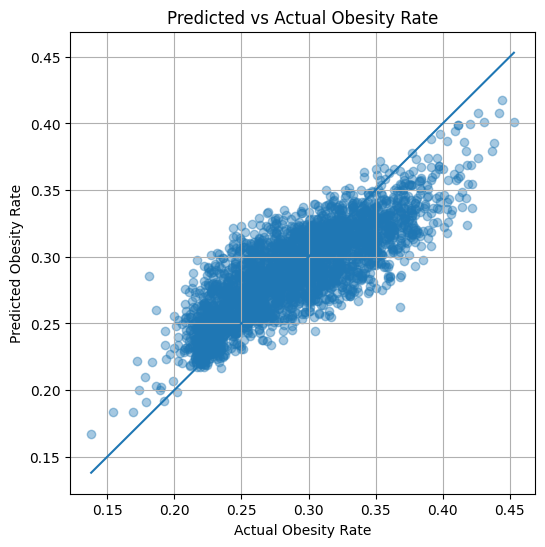

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

plt.scatter(
    df_final["obesity_rate"],
    df_final["predicted_obesity"],
    alpha=0.4
)

# Perfect prediction reference line (y = x)
min_val = min(df_final["obesity_rate"].min(), df_final["predicted_obesity"].min())
max_val = max(df_final["obesity_rate"].max(), df_final["predicted_obesity"].max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.xlabel("Actual Obesity Rate")
plt.ylabel("Predicted Obesity Rate")
plt.title("Predicted vs Actual Obesity Rate")
plt.grid(True)
plt.show()


In [ ]:
df_final[["obesity_rate", "predicted_obesity"]]

,obesity_rate,predicted_obesity
0,0.222000,0.264415
1,0.293000,0.274677
2,0.274000,0.277063
3,0.310000,0.285623
4,0.307001,0.287434
...,...,...
3116,0.340004,0.287941
3117,0.154001,0.183447
3118,0.283016,0.294092
3119,0.246022,0.266354


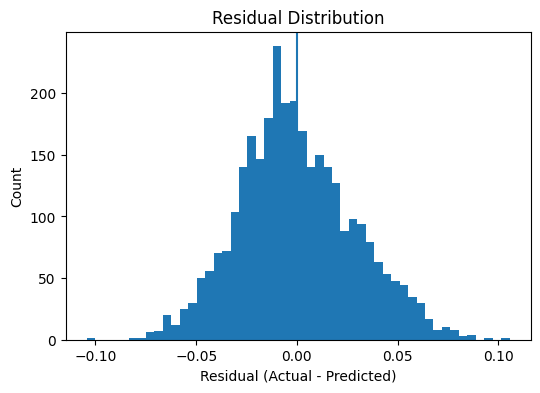

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(df_final["residual"], bins=50)
plt.axvline(0)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.show()


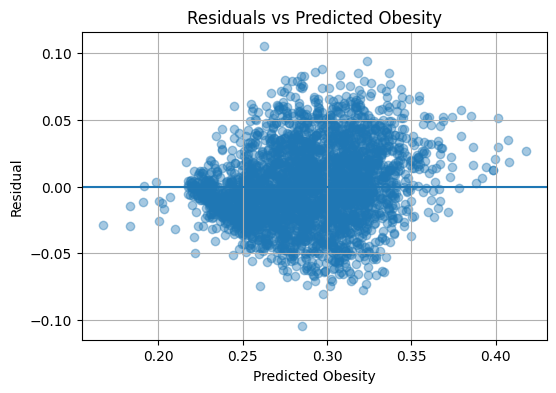

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(
    df_final["predicted_obesity"],
    df_final["residual"],
    alpha=0.4
)

plt.axhline(0)
plt.xlabel("Predicted Obesity")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted Obesity")
plt.grid(True)
plt.show()


In [ ]:
corr_pred_actual = df_final["obesity_rate"].corr(df_final["predicted_obesity"])
corr_pred_actual


np.float64(0.8159746982153504)

In [ ]:
# Create income quintiles
df_final["income_quintile"] = pd.qcut(
    df_final["median_household_income"],
    5,
    labels=["Q1 (Lowest)", "Q2", "Q3", "Q4", "Q5 (Highest)"]
)

# Compute absolute error
df_final["abs_error"] = np.abs(df_final["residual"])

# Group by income quintile
err_by_income = df_final.groupby("income_quintile")["abs_error"].mean()

# Plot
plt.figure(figsize=(7, 4))
err_by_income.plot(kind="bar")
plt.ylabel("Mean Absolute Error")
plt.title("Prediction Error by Income Quintile")
plt.show()


In [ ]:
df_final["abs_error"] = abs(
    df_final["obesity_rate"] - df_final["predicted_obesity"]
)

df_final.sort_values("abs_error", ascending=False).head(10)[
    ["GEOID", "CTYNAME", "STNAME",
     "obesity_rate", "predicted_obesity", "abs_error"]
]


,GEOID,CTYNAME,STNAME,obesity_rate,predicted_obesity,abs_error
1336,08087,Morgan County,Colorado,0.368012,0.262490,0.105523
152,12085,Martin County,Florida,0.181001,0.285282,0.104281
2441,36033,Franklin County,New York,0.418002,0.323905,0.094098
1092,53015,Cowlitz County,Washington,0.385002,0.297271,0.087730
258,19105,Jones County,Iowa,0.379005,0.292889,0.086117
1539,19197,Wright County,Iowa,0.422032,0.336667,0.085365
772,40081,Lincoln County,Oklahoma,0.403014,0.318124,0.084891
3031,55027,Dodge County,Wisconsin,0.391002,0.307676,0.083326
1922,26073,Isabella County,Michigan,0.368005,0.284823,0.083182
266,19181,Warren County,Iowa,0.369000,0.286492,0.082508


# Finding Hotspots

In [ ]:
top_10pct_worst = df_final.sort_values(
    "residual", ascending=False
).head(int(0.10 * len(df_final)))

top_10pct_worst_table = top_10pct_worst[
    ["GEOID", "CTYNAME", "STNAME",
     "obesity_rate", "predicted_obesity", "residual",
     "physical_inactivity_rate", "poverty_rate"]
]

top_10pct_worst_table


,GEOID,CTYNAME,STNAME,obesity_rate,predicted_obesity,residual,physical_inactivity_rate,poverty_rate
1336,08087,Morgan County,Colorado,0.368012,0.262490,0.105523,0.207004,0.119003
2441,36033,Franklin County,New York,0.418002,0.323905,0.094098,0.262001,0.181003
1092,53015,Cowlitz County,Washington,0.385002,0.297271,0.087730,0.209000,0.126000
258,19105,Jones County,Iowa,0.379005,0.292889,0.086117,0.220006,0.095003
1539,19197,Wright County,Iowa,0.422032,0.336667,0.085365,0.281003,0.110000
...,...,...,...,...,...,...,...,...
85,06065,Riverside County,California,0.330000,0.290834,0.039166,0.209000,0.113000
543,27137,St. Louis County,Minnesota,0.320001,0.280839,0.039161,0.198000,0.128001
1074,51179,Stafford County,Virginia,0.322002,0.282915,0.039087,0.190001,0.054000
616,37035,Catawba County,North Carolina,0.362001,0.322920,0.039082,0.257001,0.133001


In [ ]:
top_10pct_best = df_final.sort_values(
    "residual", ascending=True
).head(int(0.10 * len(df_final)))

top_10pct_best_table = top_10pct_best[
    ["GEOID", "CTYNAME", "STNAME",
     "obesity_rate", "predicted_obesity", "residual",
     "physical_inactivity_rate", "poverty_rate"]
]

top_10pct_best_table


,GEOID,CTYNAME,STNAME,obesity_rate,predicted_obesity,residual,physical_inactivity_rate,poverty_rate
152,12085,Martin County,Florida,0.181001,0.285282,-0.104281,0.238001,0.089000
563,29063,DeKalb County,Missouri,0.217006,0.297456,-0.080450,0.257008,0.146012
1359,12045,Gulf County,Florida,0.244003,0.321523,-0.077520,0.305024,0.140000
1667,18139,Rush County,Indiana,0.227003,0.301509,-0.074506,0.284009,0.110002
2648,46027,Clay County,South Dakota,0.186017,0.260296,-0.074279,0.207003,0.190013
...,...,...,...,...,...,...,...,...
1004,51003,Albemarle County,Virginia,0.236002,0.271763,-0.035762,0.192001,0.067000
3104,56009,Converse County,Wyoming,0.272009,0.307694,-0.035684,0.265004,0.092001
3115,56035,Sublette County,Wyoming,0.209011,0.244678,-0.035667,0.196013,0.072001
1840,21217,Taylor County,Kentucky,0.304002,0.339542,-0.035541,0.334017,0.164006


In [ ]:
state_residual_worst = (
    df_final
    .groupby("STNAME")["residual"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

state_residual_worst


,residual
STNAME,
Maryland,0.023656
Delaware,0.022914
West Virginia,0.018528
Utah,0.017862
Nebraska,0.016622
Michigan,0.014571
Ohio,0.014325
Washington,0.013346
Iowa,0.013114


In [ ]:
state_residual_best = (
    df_final
    .groupby("STNAME")["residual"]
    .mean()
    .sort_values()
    .head(10)
)

state_residual_best


,residual
STNAME,
Massachusetts,-0.033581
Hawaii,-0.019553
Rhode Island,-0.016411
Illinois,-0.015472
Georgia,-0.012070
South Dakota,-0.011653
Florida,-0.010726
North Carolina,-0.009715
California,-0.009164


In [ ]:
top_10pct_worst_table.to_csv("top_10pct_worst_residual_counties.csv", index=False)
top_10pct_best_table.to_csv("top_10pct_best_residual_counties.csv", index=False)

state_residual_worst.to_csv("state_worst_residual.csv")
state_residual_best.to_csv("state_best_residual.csv")


# Run after MCDM

In [ ]:
best_overall = max(results_pipeline, key=lambda x: x["Best_R2"])
best_model_final = best_overall["Best_Estimator"]


In [ ]:
MCDM_DATASET = "/content/drive/My Drive/obesity-risk-analytics/dashboard_data_final/"

In [ ]:

df_risk = pd.read_csv(
    os.path.join(MCDM_DATASET, "dashboard_risk_data.csv"),
    dtype={"GEOID": str}
)

df_risk["GEOID"] = df_risk["GEOID"].str.zfill(5)

# df_risk = pd.read_csv(MCDM_DATASET + "dashboard_risk_data.csv")

df_risk.columns


Index(['GEOID', 'CTYNAME', 'STNAME', 'obesity_rate',
       'physical_inactivity_rate', 'poverty_rate', 'low_access_food_rate',
       'median_household_income', 'unemployment_rate', 'risk_score_all',
       'risk_rank_all', 'risk_score_heal', 'risk_rank_heal', 'pct_white',
       'pct_black', 'pct_hispanic', 'pct_asian', 'pct_native'],
      dtype='object')

In [ ]:
df_final_with_predictions = df_risk.merge(
    df_final[[
        "GEOID",
        "predicted_obesity",
        "residual",
        "high_obesity",
        "abs_error"
    ]],
    on="GEOID",
    how="left"
)


In [ ]:
df_final_with_predictions.columns


Index(['GEOID', 'CTYNAME', 'STNAME', 'obesity_rate',
       'physical_inactivity_rate', 'poverty_rate', 'low_access_food_rate',
       'median_household_income', 'unemployment_rate', 'risk_score_all',
       'risk_rank_all', 'risk_score_heal', 'risk_rank_heal', 'pct_white',
       'pct_black', 'pct_hispanic', 'pct_asian', 'pct_native',
       'predicted_obesity', 'residual', 'high_obesity', 'abs_error'],
      dtype='object')

In [ ]:
df_final_with_predictions.to_csv(
    "/content/drive/My Drive/obesity-risk-analytics/data/processed_final/df_final_with_predictions.csv", index=False
)
